# Edited by Ashen; 微信公众号:爱研思谈; Github:AshenOneme

### OpenSeespy添加任意截面
### 从ABAQUS中绘图并导入Python计算纤维坐标、纤维面积和纤维属性

In [11]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
from pylab import *
import os

In [12]:
ops.wipe() # 初始清空
ops.model('basic', '-ndm', 2, '-ndf', 3)  # frame 2D
IDSteel = 1
Fy_Steel = 400
E0_Steel = 206000
bs_Steel = 0.005
R0 = 12.5
cR1 = 0.925
cR2 = 0.15
ops.uniaxialMaterial('Steel02', IDSteel, Fy_Steel, E0_Steel, bs_Steel,R0,cR1,cR2)

IDcoverC=2
fpc_cover=-40
epsc0_cover=-0.002
fpcu_cover=-8
epsU_cover=-0.004
ops.uniaxialMaterial('Concrete01', IDcoverC, fpc_cover, epsc0_cover, fpcu_cover, epsU_cover)

IDcoreC=3
fpc_core=-40
epsc0_core=-0.0024
fpcu_core=-18
epsU_core=-0.006
ops.uniaxialMaterial('Concrete01', IDcoreC, fpc_core, epsc0_core, fpcu_core, epsU_core)


In [13]:
nc1, nr1 = 8, 3
nc2, nr2 = 8, 2
ri1, re1 = 100,200
ri2, re2 = 200,250
a_beg, a_end = 0., 360.
rbar3 = 225
a_beg2, a_end2 = 0., 360.
As_bar=3.14*8*8

fiber_column_section=1
ops.section('Fiber', fiber_column_section)
ops.patch('circ', IDcoreC, nc1, nr1, 0., 0., ri1, re1, a_beg, a_end)
ops.patch('circ', IDcoverC, nc2, nr2, 0., 0., ri2, re2, a_beg, a_end)
ops.layer('circ', IDSteel, 7, As_bar, 0., 0., rbar3, a_beg2, a_end2)

### OpenSeespy中的纤维截面信息

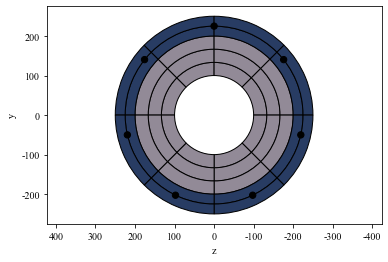

In [14]:
fib_sec_circular = [['section', 'Fiber', 1, '-GJ', 1.0e6],
             ['patch', 'circ', IDcoreC-1, nc1, nr1, 0., 0., ri1, re1, a_beg, a_end],
             ['patch', 'circ', IDcoverC-1, nc2, nr2, 0., 0., ri2, re2, a_beg, a_end],
             ['layer', 'circ', IDSteel-1, 7, As_bar, 0., 0., rbar3, a_beg2, a_end2],
             ]

matcolor = ['#283c63','#928a97']
opsv.plot_fiber_section(fib_sec_circular, matcolor=matcolor)
plt.axis('equal')
plt.show()

### Abaqus导入节点计算，并查看截面

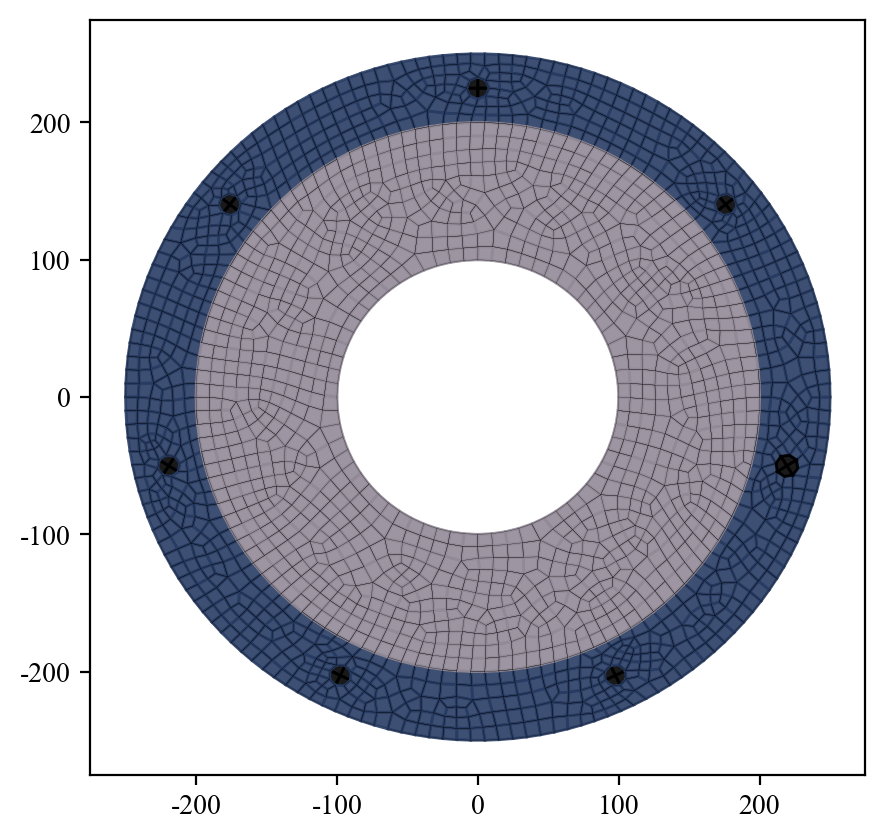

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(num=1, figsize=(5, 5),dpi=200)

Element_Abaqus_Load=np.loadtxt('Element.txt',skiprows=1,delimiter=',')
Node_Abaqus_Load=np.loadtxt('Node.txt',skiprows=1,delimiter=',')
Steel_Abaqus_Load=np.loadtxt('Steel.txt',skiprows=1,delimiter=',')
OpenSees_Import=np.empty([0,4])
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

for Element in Element_Abaqus_Load:
    Temp_Import=np.zeros([1,4])
    ElementTag=int(Element[0])
    Element1=int(Element[1])
    Element2=int(Element[2])
    Element3=int(Element[3])
    Element4=int(Element[4])
    Element1_Coordinate=Node_Abaqus_Load[Element1-1,[1,2]]
    Element2_Coordinate=Node_Abaqus_Load[Element2-1,[1,2]]
    Element3_Coordinate=Node_Abaqus_Load[Element3-1,[1,2]]
    Element4_Coordinate=Node_Abaqus_Load[Element4-1,[1,2]]
    Element_Coordinate=(Element1_Coordinate+Element2_Coordinate+Element3_Coordinate+Element4_Coordinate)/4
    x = [Element1_Coordinate[0],Element2_Coordinate[0],Element3_Coordinate[0],Element4_Coordinate[0]]
    y = [Element1_Coordinate[1],Element2_Coordinate[1],Element3_Coordinate[1],Element4_Coordinate[1]]
    Element_Area= PolyArea(x,y)

    Temp_Import[0,0]=Element_Coordinate[0]
    Temp_Import[0,1]=Element_Coordinate[1]
    Temp_Import[0,2]=Element_Area
    
    if ElementTag<=1002:
        if ElementTag not in Steel_Abaqus_Load:
            plt.fill(x,y,color="#283c63", alpha=0.9)
            plt.plot(x,y,color="k", alpha=0.9,linewidth=0.1)
            Temp_Import[0,3]=IDcoverC
        else:
            plt.fill(x,y,color="k", alpha=0.9)
            Temp_Import[0,3]=IDSteel
    if ElementTag>1002:
        if ElementTag not in Steel_Abaqus_Load:
            plt.fill(x,y,color="#928a97", alpha=0.9)
            plt.plot(x,y,color="k", alpha=0.9,linewidth=0.1)
            Temp_Import[0,3]=IDcoreC
        else:
            plt.fill(x,y,color="k", alpha=0.9) 
            Temp_Import[0,3]=IDSteel
    OpenSees_Import=np.append(OpenSees_Import,Temp_Import,axis=0)
plt.show()
np.savetxt('OpenSees_Import.txt',OpenSees_Import)


### OpenSees截面信息

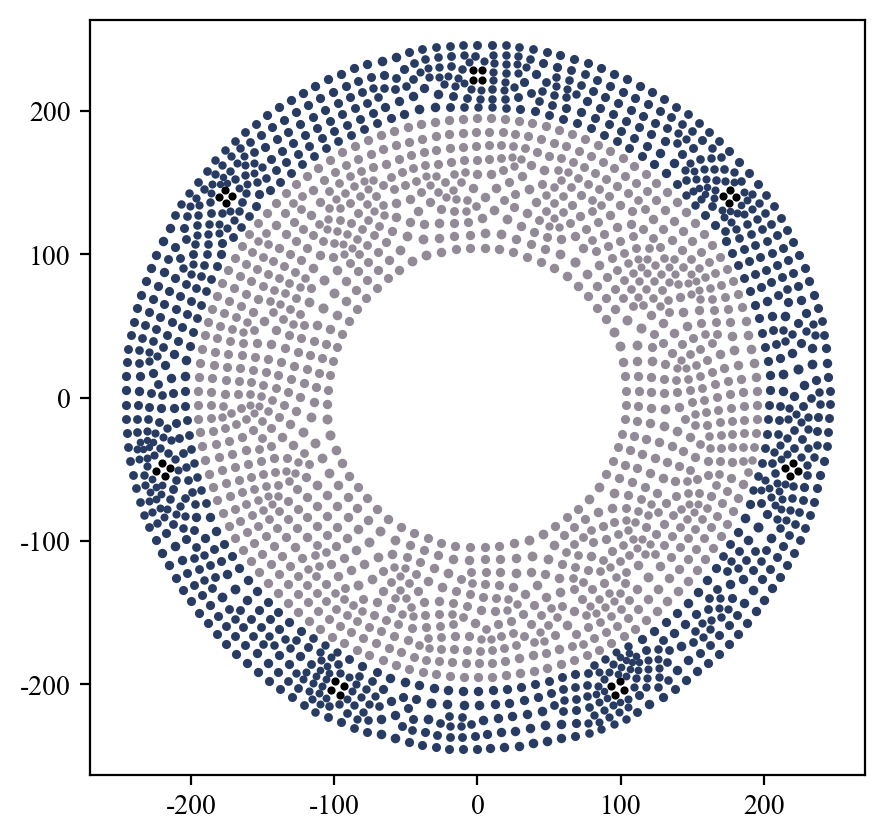

In [16]:
OpenSees_Import=np.loadtxt('OpenSees_Import.txt')
fig = plt.figure(num=1, figsize=(5, 5),dpi=200)
for fiber in OpenSees_Import:
    y=fiber[0]
    z=fiber[1]
    A=fiber[2]
    mat=fiber[3]
    r=np.sqrt(A/np.pi)
    if mat==IDcoreC:
        plt.scatter(y,z,s=r,color='#928a97')
    if mat==IDcoverC:
        plt.scatter(y,z,s=r,color='#283c63')
    if mat==IDSteel:
        plt.scatter(y,z,s=r,color='k')
plt.axis('equal')
plt.show()


### OpenSees自带截面功能分析

In [17]:
ops.wipe() # 初始清空
ops.model('basic', '-ndm', 2, '-ndf', 3)  # frame 2D
IDSteel = 1
Fy_Steel = 400
E0_Steel = 206000
bs_Steel = 0.005
R0 = 12.5
cR1 = 0.925
cR2 = 0.15
ops.uniaxialMaterial('Steel02', IDSteel, Fy_Steel, E0_Steel, bs_Steel,R0,cR1,cR2)

IDcoverC=2
fpc_cover=-40
epsc0_cover=-0.002
fpcu_cover=-8
epsU_cover=-0.004
ops.uniaxialMaterial('Concrete01', IDcoverC, fpc_cover, epsc0_cover, fpcu_cover, epsU_cover)

IDcoreC=3
fpc_core=-40
epsc0_core=-0.0024
fpcu_core=-18
epsU_core=-0.006
ops.uniaxialMaterial('Concrete01', IDcoreC, fpc_core, epsc0_core, fpcu_core, epsU_core)

nc1, nr1 = 8, 3
nc2, nr2 = 8, 2
ri1, re1 = 100,200
ri2, re2 = 200,250
a_beg, a_end = 0., 360.
rbar3 = 225
a_beg2, a_end2 = 0., 360.
As_bar=3.14*8*8

fiber_column_section=1
ops.section('Fiber', fiber_column_section)
ops.patch('circ', IDcoreC, nc1, nr1, 0., 0., ri1, re1, a_beg, a_end)
ops.patch('circ', IDcoverC, nc2, nr2, 0., 0., ri2, re2, a_beg, a_end)
ops.layer('circ', IDSteel, 7, As_bar, 0., 0., rbar3, a_beg2, a_end2)

# 节点坐标(x,y)
ops.node(1,0,0)
ops.node(2,0,800)
ops.node(3,0,1600)
ops.node(4,0,2400)
ops.node(5,0,3200)

#1节点的x平动,y平动,转动固定
ops.fix(1,1,1,1)

coordTransf = "Linear"  # Linear, PDelta, Corotational
IDColumnTransf=1
ops.geomTransf(coordTransf, IDColumnTransf)
numIntgrPts=4

ops.element('nonlinearBeamColumn', 1, 1 ,2, numIntgrPts, fiber_column_section, IDColumnTransf)
ops.element('nonlinearBeamColumn', 2, 2, 3, numIntgrPts, fiber_column_section ,IDColumnTransf)
ops.element('nonlinearBeamColumn', 3, 3, 4, numIntgrPts, fiber_column_section ,IDColumnTransf)
ops.element('nonlinearBeamColumn', 4, 4, 5, numIntgrPts, fiber_column_section ,IDColumnTransf)

ops.timeSeries('Linear', 11)
ops.pattern('Plain', 100,11)
ops.load(5,0,-9.17e5,0)
ops.constraints("Penalty",1e20,1e20)
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test('NormDispIncr', 1e-5, 2000)
ops.algorithm("KrylovNewton")
ops.integrator("LoadControl",0.1)
ops.analysis("Static")
ops.analyze(10)
ops.loadConst("-time",0.0)

ops.recorder('Node', '-file', "Disp_OSsec.txt","-time",'-node', 5, '-dof',1, 'disp')
ops.recorder('Node', '-file', "Reaction_OSsec.txt","-time",'-node', 1, '-dof',1, 'reaction')

ops.timeSeries('Linear', 22)
ops.pattern( "Plain", 200,22)
ops.sp(5,1,1)
ops.test('NormDispIncr', 1e-4, 2000)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(200*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(400*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(600*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(800*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1000*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(1200*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1400*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(1600*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1800*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2000*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(2200*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2400*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(2600*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2800*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3000*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(3200*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3400*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(3600*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3800*10)

0

### ABAQUS导入截面计算结果

In [18]:
ops.wipe() # 初始清空
ops.model('basic', '-ndm', 2, '-ndf', 3)  # frame 2D
IDSteel = 1
Fy_Steel = 400
E0_Steel = 206000
bs_Steel = 0.005
R0 = 12.5
cR1 = 0.925
cR2 = 0.15
ops.uniaxialMaterial('Steel02', IDSteel, Fy_Steel, E0_Steel, bs_Steel,R0,cR1,cR2)

IDcoverC=2
fpc_cover=-40
epsc0_cover=-0.002
fpcu_cover=-8
epsU_cover=-0.004
ops.uniaxialMaterial('Concrete01', IDcoverC, fpc_cover, epsc0_cover, fpcu_cover, epsU_cover)

IDcoreC=3
fpc_core=-40
epsc0_core=-0.0024
fpcu_core=-18
epsU_core=-0.006
ops.uniaxialMaterial('Concrete01', IDcoreC, fpc_core, epsc0_core, fpcu_core, epsU_core)


OpenSees_Import=np.loadtxt('OpenSees_Import.txt')
fiber_column_section=1
ops.section('Fiber', fiber_column_section)
for fiber in OpenSees_Import:
    y=fiber[0]
    z=fiber[1]
    A=fiber[2]
    mat=int(fiber[3])
    ops.fiber(y,z,A,mat)


# 节点坐标(x,y)
ops.node(1,0,0)
ops.node(2,0,800)
ops.node(3,0,1600)
ops.node(4,0,2400)
ops.node(5,0,3200)

#1节点的x平动,y平动,转动固定
ops.fix(1,1,1,1)

coordTransf = "Linear"  # Linear, PDelta, Corotational
IDColumnTransf=1
ops.geomTransf(coordTransf, IDColumnTransf)
numIntgrPts=4

ops.element('nonlinearBeamColumn', 1, 1 ,2, numIntgrPts, fiber_column_section, IDColumnTransf)
ops.element('nonlinearBeamColumn', 2, 2, 3, numIntgrPts, fiber_column_section ,IDColumnTransf)
ops.element('nonlinearBeamColumn', 3, 3, 4, numIntgrPts, fiber_column_section ,IDColumnTransf)
ops.element('nonlinearBeamColumn', 4, 4, 5, numIntgrPts, fiber_column_section ,IDColumnTransf)

ops.timeSeries('Linear', 11)
ops.pattern('Plain', 100,11)
ops.load(5,0,-9.17e5,0)
ops.constraints("Penalty",1e20,1e20)
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test('NormDispIncr', 1e-5, 2000)
ops.algorithm("KrylovNewton")
ops.integrator("LoadControl",0.1)
ops.analysis("Static")
ops.analyze(10)
ops.loadConst("-time",0.0)

ops.recorder('Node', '-file', "Disp_Abasec.txt","-time",'-node', 5, '-dof',1, 'disp')
ops.recorder('Node', '-file', "Reaction_Abasec.txt","-time",'-node', 1, '-dof',1, 'reaction')

ops.timeSeries('Linear', 22)
ops.pattern( "Plain", 200,22)
ops.sp(5,1,1)
ops.test('NormDispIncr', 1e-4, 2000)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(200*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(400*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(600*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(800*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1000*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(1200*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1400*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(1600*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(1800*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2000*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(2200*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2400*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(2600*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(2800*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3000*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(3200*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3400*10)

ops.integrator("DisplacementControl",5,1,0.01)
ops.analysis("Static")
ops.analyze(3600*10)

ops.integrator("DisplacementControl",5,1,-0.01)
ops.analysis("Static")
ops.analyze(3800*10)

0

### 计算结果对比

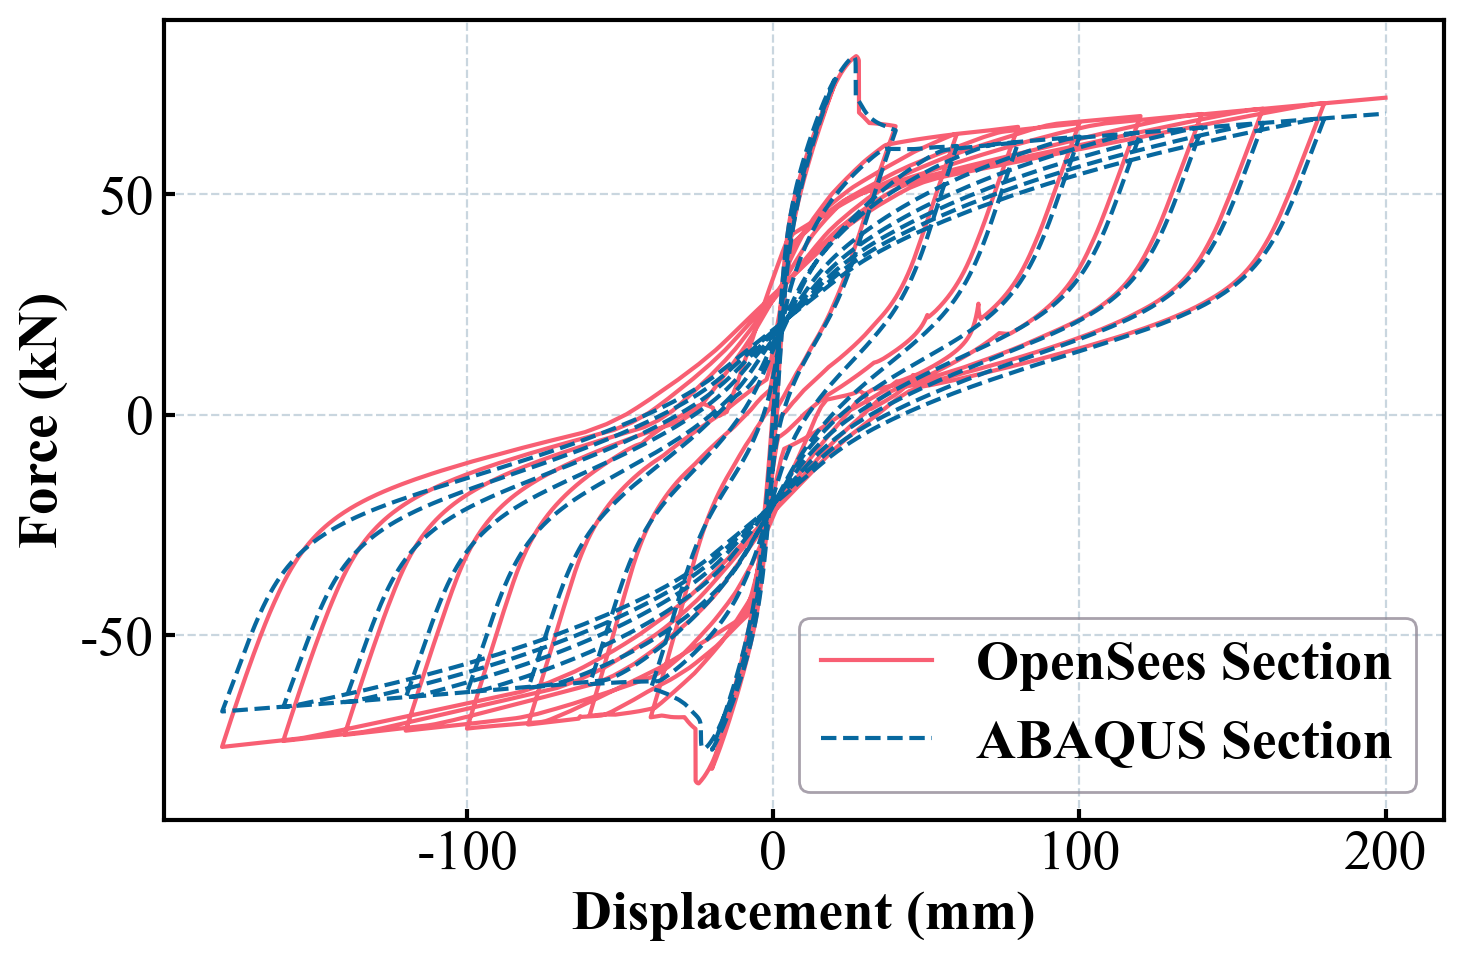

In [20]:
ops.wipe()
Disp_OSsec=np.loadtxt('Disp_OSsec.txt',usecols=1)
Force_OSsec=np.loadtxt('Reaction_OSsec.txt',usecols=1)
Disp_Abasec=np.loadtxt('Disp_Abasec.txt',usecols=1)
Force_Abasec=np.loadtxt('Reaction_Abasec.txt',usecols=1)
font_Times_New_Roman={"family":"Times New Roman",
                      # "style": "italic",
                      "weight":"heavy",
                      "size":20}
font_Song={"family":"SimSun",
           "style":"italic",
           "weight":"heavy",
           "size":20}
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rc('axes', unicode_minus=False)
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5),dpi=200)
fig.subplots_adjust(left=0.15,right=0.95,top=0.95,bottom=0.15)
bwith = 1.5 
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
plt.plot(-Disp_OSsec,Force_OSsec/1000,label='OpenSees Section',color='#f85f73',linestyle='-')
plt.plot(-Disp_Abasec,Force_Abasec/1000,label='ABAQUS Section',color='#07689f',linestyle='--')
ax.tick_params(axis='x',which='major',direction='in',labelsize=20,length=4,width=1.5) 
ax.tick_params(axis='x',which='minor',direction='in',color='#393e46',labelsize=20,length=2,width=1)
ax.tick_params(axis='y',which='major',direction='in',labelsize=20,length=4,width=1.5)
ax.tick_params(axis='y',which='minor',direction='in',color='#393e46',labelsize=20,length=2,width=1) 
ax.grid(linestyle='--',color='#c9d6df')                      
ax.set_xlabel('Displacement (mm)',fontproperties=font_Times_New_Roman)
ax.set_ylabel('Force (kN)',fontproperties=font_Times_New_Roman)
plt.legend(prop=font_Times_New_Roman,edgecolor='#928a97',facecolor='none')
plt.show()